# 1. Imports

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import math as m
import random
import numpy as np
from urllib import request
import gzip
import pickle
import os

# Dataset Loader: load_synth

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    np.random.seed(seed)
    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])
    ntotal = num_train + num_val
    x = np.random.randn(ntotal, 2)
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(int)
    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

# 2. NN Architecture Visualization

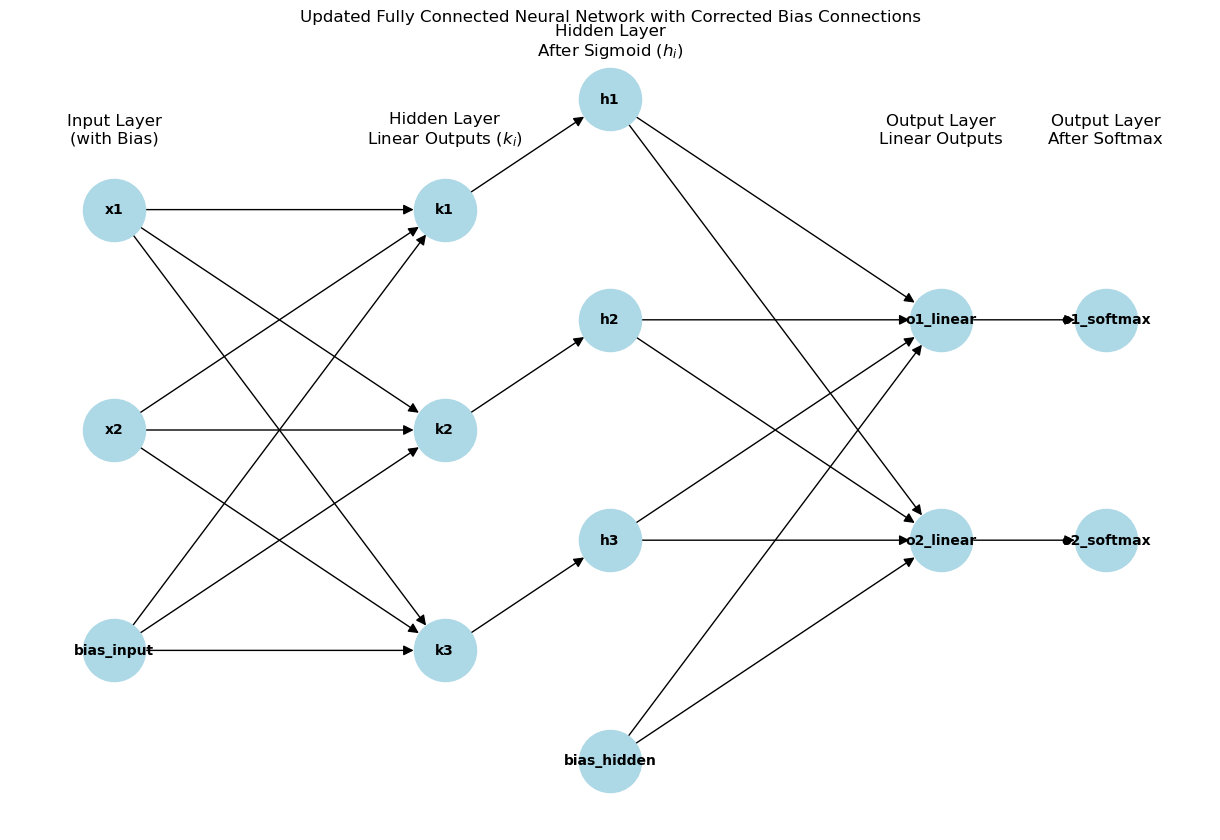

In [19]:
layers_updated = {
    "Input": ["x1", "x2", "bias_input"],
    "Hidden_linear_output": ["k1", "k2", "k3"],
    "Hidden_after_sigmoid": ["h1", "h2", "h3", "bias_hidden"],
    "Output_linear_output": ["o1_linear", "o2_linear"],
    "Output_after_softmax": ["o1_softmax", "o2_softmax"]
}

G_updated = nx.DiGraph()
layer_positions_updated = {
    "Input": (0, 0),
    "Hidden_linear_output": (1, 0),
    "Hidden_after_sigmoid": (1.5, 0),
    "Output_linear_output": (2.5, 0),
    "Output_after_softmax": (3, 0)
}
positions_updated = {}
for layer, nodes in layers_updated.items():
    y_offset = len(nodes) / 2.0
    for i, node in enumerate(nodes):
        positions_updated[node] = (layer_positions_updated[layer][0], layer_positions_updated[layer][1] - i + y_offset)
        G_updated.add_node(node, layer=layer)

for input_node in layers_updated["Input"][:-1]:
    for hidden_linear_node in layers_updated["Hidden_linear_output"]:
        G_updated.add_edge(input_node, hidden_linear_node)
for hidden_linear_node in layers_updated["Hidden_linear_output"]:
    G_updated.add_edge("bias_input", hidden_linear_node)
for hidden_linear_node, hidden_after_node in zip(layers_updated["Hidden_linear_output"], layers_updated["Hidden_after_sigmoid"][:-1]):
    G_updated.add_edge(hidden_linear_node, hidden_after_node)
for hidden_after_node in layers_updated["Hidden_after_sigmoid"][:-1]:
    for output_linear_node in layers_updated["Output_linear_output"]:
        G_updated.add_edge(hidden_after_node, output_linear_node)
for output_linear_node in layers_updated["Output_linear_output"]:
    G_updated.add_edge("bias_hidden", output_linear_node)
for output_linear_node, output_softmax_node in zip(layers_updated["Output_linear_output"], layers_updated["Output_after_softmax"]):
    G_updated.add_edge(output_linear_node, output_softmax_node)

plt.figure(figsize=(12, 8))
nx.draw(G_updated, pos=positions_updated, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrowsize=15)
plt.text(0, 1.8, "Input Layer\n(with Bias)", fontsize=12, ha='center')
plt.text(1, 1.8, "Hidden Layer\nLinear Outputs ($k_i$)", fontsize=12, ha='center')
plt.text(1.5, 2.2, "Hidden Layer\nAfter Sigmoid ($h_i$)", fontsize=12, ha='center')
plt.text(2.5, 1.8, "Output Layer\nLinear Outputs", fontsize=12, ha='center')
plt.text(3, 1.8, "Output Layer\nAfter Softmax", fontsize=12, ha='center')
plt.title("Updated Fully Connected Neural Network with Corrected Bias Connections")
plt.savefig("Neural_net")
plt.show()

# 3. Scalar Forward and Backward Pass

In [21]:
x = [1., -1.]
t = [1, 0]

w = [[1., 1., 1.], 
     [-1., -1., -1.]]
v = [[1., 1.], 
     [-1., -1.], 
     [-1., -1.]]

b_in = [0., 0., 0.]
b_hidden = [0., 0.]

def sigmoid(x):
    return 1 / (1 + m.exp(-x))

def softmax(x):
    exp_values = [m.exp(i) for i in x]
    total = sum(exp_values)
    return [i / total for i in exp_values]

def forwardpass(x, w, v, b_in, b_hidden, t):
    k = [sum(w[i][j] * x[i] for i in range(len(x))) + b_in[j] for j in range(len(w[0]))]
    h = [sigmoid(kj) for kj in k]
    o = [sum(v[i][j] * h[i] for i in range(len(h))) + b_hidden[j] for j in range(len(v[0]))]
    y = softmax(o)
    loss = sum(-t[j] * m.log(y[j]) for j in range(len(y)))
    return k, h, o, y, loss

def backward_pass(y, t, h, x, v, b_hidden, b_in):
    delta = [y_j - t_j for y_j, t_j in zip(y, t)]
    v_prime = [[delta[j] * h[i] for j in range(len(delta))] for i in range(len(h))]
    h_prime = [sum(delta[j] * v[i][j] for j in range(len(delta))) for i in range(len(h))]
    k_prime = [h_prime[i] * h[i] * (1 - h[i]) for i in range(len(h))]
    w_prime = [[k_prime[j] * x[i] for j in range(len(k_prime))] for i in range(len(x))]
    b_prime_hidden = delta[:]
    b_prime_input = k_prime[:]
    return v_prime, w_prime, b_prime_hidden, b_prime_input

k, h, o, y, loss = forwardpass(x, w, v, b_in, b_hidden, t)
print("Output after softmax:", y)
print("Loss:", loss)

v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y, t, h, x, v, b_hidden, b_in)
print("Gradient wrt v:", v_prime)
print("Gradient wrt w:", w_prime)

Output after softmax: [0.5, 0.5]
Loss: 0.6931471805599453
Gradient wrt v: [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
Gradient wrt w: [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]


# 4. Training Scalar MLP on Synthetic Data

Epoch 1/50, Loss: 0.6804
Epoch 2/50, Loss: 0.3753
Epoch 3/50, Loss: 0.1995
Epoch 4/50, Loss: 0.1872
Epoch 5/50, Loss: 0.1839
Epoch 6/50, Loss: 0.1821
Epoch 7/50, Loss: 0.1808
Epoch 8/50, Loss: 0.1799
Epoch 9/50, Loss: 0.1790
Epoch 10/50, Loss: 0.1783
Epoch 11/50, Loss: 0.1777
Epoch 12/50, Loss: 0.1772
Epoch 13/50, Loss: 0.1767
Epoch 14/50, Loss: 0.1763
Epoch 15/50, Loss: 0.1758
Epoch 16/50, Loss: 0.1755
Epoch 17/50, Loss: 0.1751
Epoch 18/50, Loss: 0.1748
Epoch 19/50, Loss: 0.1745
Epoch 20/50, Loss: 0.1742
Epoch 21/50, Loss: 0.1739
Epoch 22/50, Loss: 0.1736
Epoch 23/50, Loss: 0.1734
Epoch 24/50, Loss: 0.1732
Epoch 25/50, Loss: 0.1729
Epoch 26/50, Loss: 0.1727
Epoch 27/50, Loss: 0.1725
Epoch 28/50, Loss: 0.1723
Epoch 29/50, Loss: 0.1721
Epoch 30/50, Loss: 0.1720
Epoch 31/50, Loss: 0.1718
Epoch 32/50, Loss: 0.1716
Epoch 33/50, Loss: 0.1715
Epoch 34/50, Loss: 0.1713
Epoch 35/50, Loss: 0.1712
Epoch 36/50, Loss: 0.1710
Epoch 37/50, Loss: 0.1709
Epoch 38/50, Loss: 0.1708
Epoch 39/50, Loss: 0.

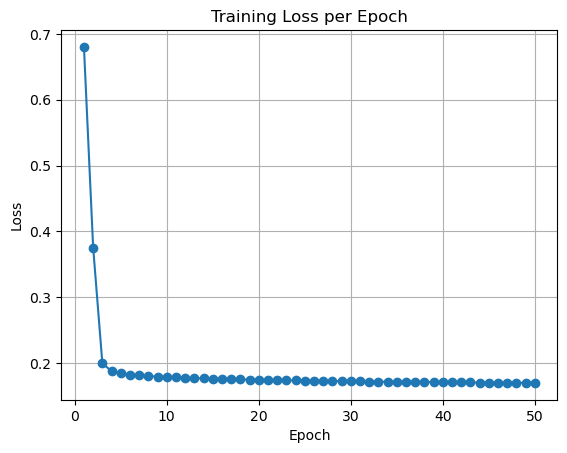

In [23]:
# data normalization
(xtrain, ytrain), (xval, yval), num_cls = load_synth()
xtrain = [list(i) for i in xtrain]
X_1 = [i[0] for i in xtrain]
X_2 = [i[1] for i in xtrain]
for i in xtrain:
    i[0] /= max(X_1)
    i[1] /= max(X_2)

num_inputs = 2
num_hidden_units = 3
num_outputs = 2

w_train = [[random.gauss(-1, 1) for _ in range(num_hidden_units)] for _ in range(num_inputs)]
v_train = [[random.gauss(-1, 1) for _ in range(num_outputs)] for _ in range(num_hidden_units)]

learning_rate = 0.01
epochs = 50
train_losses = []

for epoch in range(epochs):
    epoch_loss = 0
    for x_instance, target in zip(xtrain, ytrain):
        target_one_hot = [1 if i == target else 0 for i in range(num_outputs)]
        k, h, o, y, loss = forwardpass(x_instance, w_train, v_train, b_in, b_hidden, target_one_hot)
        epoch_loss += loss
        v_prime, w_prime, b_prime_hidden, b_prime_input = backward_pass(y, target_one_hot, h, x_instance, v_train, b_hidden, b_in)
        for i in range(len(w_train)):
            for j in range(len(w_train[i])):
                w_train[i][j] -= learning_rate * w_prime[i][j]
        for i in range(len(v_train)):
            for j in range(len(v_train[i])):
                v_train[i][j] -= learning_rate * v_prime[i][j]
        for i in range(len(b_in)):
            b_in[i] -= learning_rate * b_prime_input[i]
        for i in range(len(b_hidden)):
            b_hidden[i] -= learning_rate * b_prime_hidden[i]
    avg_epoch_loss = epoch_loss / len(xtrain)
    train_losses.append(avg_epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss:.4f}")

plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.savefig("trainloss")
plt.show()